# Mask Distribution Problem
- Essencially we solve two separate problems; 1) mask for young population and 2) mask for adults population
- Assumption: the total supply is insuffienct to satisfy all demands from the pharmacy
- Objective 1: maximize the total utility (for social welfare)
- Objecitve 2: minimize the total inequity (for fairness)

## Read data from csv file

In [ ]:
import pandas as pd

#data = pd.read_csv('small_example.csv', encoding='utf-8')
data = pd.read_csv('data_test_2.csv') # contains 1000 dong out of 3500-ish
data = data.drop(data.columns[1:3],axis=1)
data.iloc[0:2,:]

,location_id,address_3,n_pharmacies,n_young,n_adults,n_elders,intensity
0,jongro,1,5,402,180,20,0.656476
1,jung,2,3,530,70,30,0.766949


### Data processing
- create pharmacy data: each pharmacy has the same number of population for each class within the same area (location_id)

In [ ]:
import numpy as np
n = data.shape[0] # number of total locations
#n = 300
#m = data['n_pharmacies'].sum()
m = n
pharm_data =  pd.DataFrame([],index=range(0,m), columns=['pharmacy_id', 'location_id', 'n_young','n_adults','n_elders'])
print(pharm_data.shape)
counter = 0
for i in range(n):
    #nn = data.iloc[i,6]
    nn = 1
    for j in range(nn):

        pharm_data.iloc[counter,0] = data.iloc[i,0]#counter + 1
        pharm_data.iloc[counter,1] = data.iloc[i,0]
        pharm_data.iloc[counter,2] = np.ceil(data.iloc[i,3]/nn)
        pharm_data.iloc[counter,3] = np.ceil(data.iloc[i,4]/nn)
        pharm_data.iloc[counter,4] = np.ceil(data.iloc[i,5]/nn)
        counter = counter + 1
print(pharm_data)

(2, 5)
  pharmacy_id location_id n_young n_adults n_elders
0      jongro      jongro   402.0    180.0     20.0
1        jung        jung   530.0     70.0     30.0


### total supply
- total quantities are insufficient

In [ ]:
import numpy as np
supply_adults = np.ceil(0.1*data['n_adults'].sum())
supply_elders = np.ceil(0.1*(data['n_elders'].sum()))

supply_adults = supply_adults + supply_elders
print(supply_adults) # I arbitrarily set 50% of shortage
print(supply_elders)


30.0
5.0


### construct two utility functions for each pharmacy
- we assume that each pharmacy in the same 'dong' area has the same number of (potential) customers
- e.g. An area has 100 population and 2 pharmacies. Then, pharmacy 1 and 2 covers 50 and 50 population respectively in this area.
- Each pharmacy has two utility functions; 1) utility function for young population (age below 15) and 2) utility for adults inclding elders (age above 65).
- utiliy function is consisted of total population, number of breakpoints, population for each class, slope, max utility
- Each area has an intensity which shows the level of threat for COVID-19. (higher value represents higher threat)
- to begin with, we focus on the problem of the adults below.

In [ ]:
n = data.shape[0] # number of total locations
print("The number of ('dong') locations is %d." % n)

The number of ('dong') locations is 2.


In [ ]:
m = pharm_data.shape[0] # number of total pharmacies
print("The number of pharmacies is %d." % m)

The number of pharmacies is 2.


In [ ]:
total_area_population = data[['location_id', 'n_adults']].copy()  #total number of population of each "dong"
for i in range(n):
    total_area_population.iloc[i,1] = data.iloc[i,4] + data.iloc[i,5]


In [ ]:
total_population = np.zeros(m) #total number of (potential) customer of each pharmacy
for i in range(m):
    total_population[i] = pharm_data.iloc[i,3] + pharm_data.iloc[i,4]

print(total_population[0:15])
print(supply_adults)
print(sum(total_population))

[200. 100.]
30.0
300.0


In [ ]:
num_breaks = np.zeros(m) #number of breakpoints of the utility function for each pharmacy
for i in range(m):
    num_breaks[i] = 2

In [ ]:
sub_population = np.zeros([m,2]) # number of capacity of each class (adults and elders) for each pharmacy
for i in range(m):
    sub_population[i,0] = pharm_data.iloc[i,4] # number of elders (they have a higher priority)
    sub_population[i,1] = pharm_data.iloc[i,3] # number of adults

print(sub_population[0:15,:])

[[ 20. 180.]
 [ 30.  70.]]


- slope means the utility for one customer of each class (higher slope means higher benefit)

In [ ]:
slope = np.zeros([m,2]) # number of slope of each class (adults and elders) for each pharmacy
for i in range(m):
    #a = data.loc[data['location_id']==pharm_data.iloc[i,1],'intensity']
    #temp_intensity = a.iloc[0] # obtain the intensity for the i-th pharmacy
    slope[i,0] = 2 * data.iloc[i,6] #second term adjusts the utility slope
    slope[i,1] = 1 * data.iloc[i,6]

slope[0,0] = 2
slope[0,1] = 1

slope[1,0] = 2.5
slope[1,1] = 0.5

print(slope[0:10,:])

[[2.  1. ]
 [2.5 0.5]]


- maximum utility of each pharmacy (this is needed for future computation of the gini index)

In [ ]:
max_utility = np.zeros(m)
for i in range(m):
    max_utility[i] = sub_population[i,0]*slope[i,0]+sub_population[i,1]*slope[i,1]
print(max_utility[0:15])

[220. 110.]


## (Sample) utility funtion graph

[  0.  20. 200.] [  0.  40. 220.]


Text(0.5, 0.98, 'A sample utility function of pharmacy')

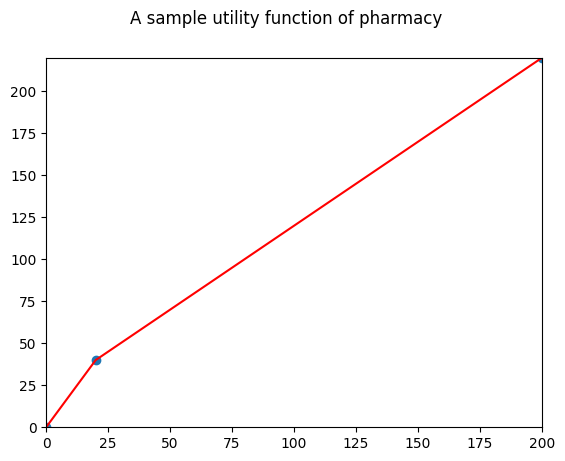

In [ ]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.array([0, sub_population[0,0],sub_population[0,0]+sub_population[0,1]], dtype=float)
y = np.array([0, sub_population[0,0]*slope[0,0],sub_population[0,0]*slope[0,0]+sub_population[0,1]*slope[0,1] ])

print(x,y)
fig, ax = plt.subplots()

plt.xlim([0, x[2]])
plt.ylim([0, y[2]])
plt.scatter(x, y)
plt.plot(x, y,"r")
fig.suptitle('A sample utility function of pharmacy', fontsize=12)

## Solve a bi-criteria optimization using $\epsilon$-constraint method

In [ ]:
#from docplex.mp.model import Model
#numPharmacies = 5000
#B = [(j,k) for j in range(numPharmacies) for k in range(numPharmacies) if k>j]
#mdl = Model("lp")
#d_plus = mdl.continuous_var_dict(B,name='d_plus')

In [ ]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 71.7 MB/s eta 0:00:00


In [ ]:
from gurobipy import Model, GRB


def solve_problem_gurobi(epsilon, supply, total_population, num_breaks, sub_population, slope, max_utility):
    import gurobipy as gp
    m = gp.Env(empty=True)
    m.setParam('WLSACCESSID', '54ea4edc-45f3-4ac2-b06f-cc4809a3c06c')
    m.setParam('WLSSECRET', '2802dfc5-13c3-4ceb-b6c2-b217b0d5994a')
    m.setParam('LICENSEID', 947226)
    m.setParam("OutputFlag", 0) #add by CHP
    m.start()

    print("epsilon: "+str(epsilon))
    print("supply: " + str(supply))


    flag = 1  # if optimal solution is found: 0, otherwise 1.
    numPharmacies = total_population.shape[0]  # number of pharmacies
    N = [i for i in range(numPharmacies)]  # define set
    M = [i for i in range(int(num_breaks[0]))]  # define set for break points
    A = [(i, t) for i in range(numPharmacies) for t in range(int(num_breaks[0]))]  # define set for x_i^t
    B = [(j, k) for j in range(numPharmacies) for k in range(numPharmacies) if k > j]

    #mdl = Model("lp")
    mdl = gp.Model(env=m)

    # define variables
    x = mdl.addVars(A, name='x', lb=0.0, vtype=GRB.CONTINUOUS)
    d_plus = mdl.addVars(B, name='d_plus', lb=0.0, vtype=GRB.CONTINUOUS)
    d_minus = mdl.addVars(B, name='d_minus', lb=0.0, vtype=GRB.CONTINUOUS)

    # define objective function
    mdl.setObjective(sum(slope[i, t] * x[i, t] for i, t in A), GRB.MAXIMIZE)

    # define constraints
    mdl.addConstr(sum(x[i, t] for i, t in A) <= supply, "constraint1")
    for i, t in A:
        mdl.addConstr(x[i, t] <= sub_population[i, t])
    for i in N:
        mdl.addConstr(sum(x[i, t] for t in M) <= total_population[i], "constraint2_%d" % i)
    for j, k in B:
        mdl.addConstr(d_plus[j, k] - d_minus[j, k] == max_utility[j] * sum(slope[k, t] * x[k, t] for t in M)
                      - max_utility[k] * sum(slope[j, t] * x[j, t] for t in M), "constraint3_%d_%d" % (j, k))
    mdl.addConstr(sum(d_plus[j, k] + d_minus[j, k] for j, k in B) <= epsilon
                  * sum(max_utility[i] for i in N) * sum(slope[i, t] * x[i, t] for i, t in A))

    mdl.setParam("OutputFlag", 0)  # Suppress Gurobi output

    mdl.optimize()

    #x_sol = {i: {t: x[i, t].X for t in range(int(num_breaks[0]))} for i in range(numPharmacies)}
    x_sol = {(i, t): x[i, t].X for i, t in A}
    x_sol_list = list(x_sol.values())
    d_plus = {(j, k): d_plus[j, k].X for j, k in B}
    d_plus_list = list(d_plus.values())
    d_minus = {(j, k): d_minus[j, k].X for j, k in B}
    d_minus_list = list(d_minus.values())
    flag = mdl.Status
    optObj = mdl.ObjVal

    return x_sol, d_plus, d_minus, optObj, flag


### solve the problem with epsilon value

In [ ]:
epsilon = 0.01

In [ ]:
x,d_plus,d_minus,obj_val,flag = solve_problem_gurobi(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)

epsilon: 0.01
supply: 30.0


In [ ]:
x

{(0, 0): 20.0,
 (0, 1): 1.3518052057094874,
 (1, 0): 8.648194794290513,
 (1, 1): 0.0}

- 4924020.000000
- 4923979.792753
- Elapsed time = 1753.23 sec. ~30 min

In [ ]:
def restore_values(numPharmacies,x,d_plus,d_minus,obj_val):

    num_value = 0
    for j in range(numPharmacies):
        for k in range(numPharmacies):
            if k>j:
                num_value = num_value + d_plus[(j,k)] + d_minus[(j,k)]
    #print(num_value)
    denom_value_1 = 0
    for i in range(numPharmacies):
        denom_value_1 = denom_value_1 + max_utility[i]
    #print(denom_value_1)
    denom_value_2 = 0
    for i in range(numPharmacies):
        for t in range(int(num_breaks[0])):
            denom_value_2 = denom_value_2 + slope[i,t]*x[(i,t)]
    #print(denom_value_2)
    gini = num_value/(denom_value_1*denom_value_2)
    # print(gini)
    return gini, obj_val

In [ ]:
numPharmacies = pharm_data.shape[0]
gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
print(gini)
print(obj_val)

0.01
62.97229219143577


In [ ]:
0.1915107507947152
4924020.0

4924020.0

## Obtain a trade-off curve between inequity vs. utility

In [ ]:
B = [0.01, 0.1, 0.3,0.5,1]
results =  pd.DataFrame([],index=range(0,len(B)), columns=['epsilon', 'inequity', 'utility'])
for i in range(len(B)):
    epsilon = B[i]
    #print(epsilon)
    x,d_plus,d_minus,obj_val,flag = solve_problem_gurobi(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)
    gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
    results.iloc[i,0] = epsilon
    results.iloc[i,1] = gini
    results.iloc[i,2] = obj_val

print(results.iloc[0:len(B)])

epsilon: 0.01
supply: 30.0
epsilon: 0.1
supply: 30.0
epsilon: 0.3
supply: 30.0
epsilon: 0.5
supply: 30.0
epsilon: 1
supply: 30.0
  epsilon  inequity    utility
0    0.01      0.01  62.972292
1     0.1       0.1  65.693431
2     0.3       0.3   68.70229
3     0.5       0.5       72.0
4       1  0.666667       75.0


Text(0.5, 0.98, 'A trade-off curve')

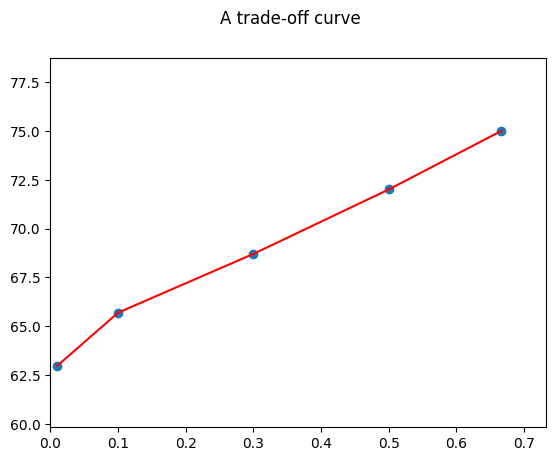

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0, 1.1* results['inequity'].max()])
plt.ylim([0.95*results['utility'].min(), 1.05*results['utility'].max()])
plt.scatter(results['inequity'], results['utility'])
plt.plot(results['inequity'], results['utility'],"r")
fig.suptitle('A trade-off curve', fontsize=12)

Text(0.5, 0.98, 'A trade-off curve')

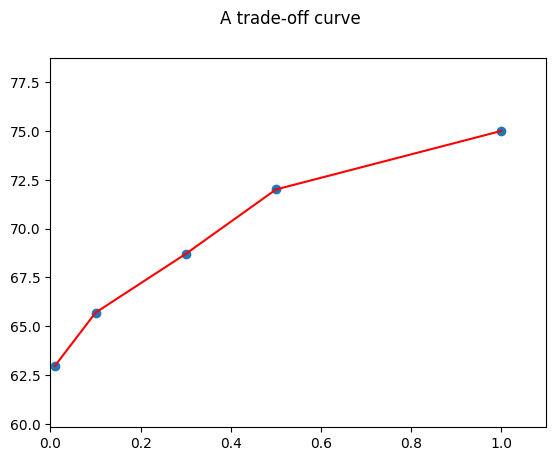

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0, 1.1* results['epsilon'].max()])
plt.ylim([0.95*results['utility'].min(), 1.05*results['utility'].max()])
plt.scatter(results['epsilon'], results['utility'])
plt.plot(results['epsilon'], results['utility'],"r")
fig.suptitle('A trade-off curve', fontsize=12)

## Restore the solution

In [ ]:
epsilon=1

x,d_plus,d_minus,obj_val,flag = solve_problem_gurobi(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)
gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
allocation_result =  pd.DataFrame([],index=range(0,m), columns=['pharmacy_id','n_adults','n_elders','allocation_qty'])
print("epsilon value is %5.2f" % epsilon)
for i in range(m):
    temp_x = 0
    for t in range(int(num_breaks[0])):
        temp_x = temp_x + x[(i,t)]

    allocation_result.iloc[i,0] = pharm_data.iloc[i,0]#i
    allocation_result.iloc[i,1] = pharm_data.iloc[i,3]
    allocation_result.iloc[i,2] = pharm_data.iloc[i,4]
    allocation_result.iloc[i,3] = temp_x

display(allocation_result)

epsilon: 1
supply: 30.0
epsilon value is  1.00


,pharmacy_id,n_adults,n_elders,allocation_qty
0,jongro,180.0,20.0,0.0
1,jung,70.0,30.0,30.0


In [ ]:
  epsilon=0.05
x,d_plus,d_minus,obj_val,flag = solve_problem_gurobi(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)
gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
allocation_result =  pd.DataFrame([],index=range(0,m), columns=['pharmacy_id','n_adults','n_elders','allocation_qty'])
print("epsilon value is %5.2f" % epsilon)
for i in range(m):
    temp_x = 0
    for t in range(int(num_breaks[0])):
        temp_x = temp_x + x[(i,t)]

    allocation_result.iloc[i,0] = pharm_data.iloc[i,0]#i
    allocation_result.iloc[i,1] = pharm_data.iloc[i,3]
    allocation_result.iloc[i,2] = pharm_data.iloc[i,4]
    allocation_result.iloc[i,3] = temp_x

display(allocation_result)


epsilon: 0.05
supply: 30.0
epsilon value is  0.05


,pharmacy_id,n_adults,n_elders,allocation_qty
0,jongro,180.0,20.0,20.04329
1,jung,70.0,30.0,9.95671


## limitation
- there is no guarantee that the higher priority purchase the mask in order
- however, we also assume that the customers randomly walked in the pharmacies. This implies the the customer will obtain the mask on average.

# Alternative model

*   Only consider utility in the model



In [ ]:
def solve_problem_gurobi_utility(supply, total_population, num_breaks, sub_population, slope, max_utility):
    import gurobipy as gp
    m = gp.Env(empty=True)
    m.setParam('WLSACCESSID', '54ea4edc-45f3-4ac2-b06f-cc4809a3c06c')
    m.setParam('WLSSECRET', '2802dfc5-13c3-4ceb-b6c2-b217b0d5994a')
    m.setParam('LICENSEID', 947226)
    m.setParam("OutputFlag", 0) #add by CHP
    m.start()

    print("epsilon: "+str(epsilon))
    print("supply: " + str(supply))


    flag = 1  # if optimal solution is found: 0, otherwise 1.
    numPharmacies = total_population.shape[0]  # number of pharmacies
    N = [i for i in range(numPharmacies)]  # define set
    M = [i for i in range(int(num_breaks[0]))]  # define set for break points
    A = [(i, t) for i in range(numPharmacies) for t in range(int(num_breaks[0]))]  # define set for x_i^t
    B = [(j, k) for j in range(numPharmacies) for k in range(numPharmacies) if k > j]

    #mdl = Model("lp")
    mdl = gp.Model(env=m)

    # define variables
    x = mdl.addVars(A, name='x', lb=0.0, vtype=GRB.CONTINUOUS)

    # define objective function
    mdl.setObjective(sum(slope[i, t] * x[i, t] for i, t in A), GRB.MAXIMIZE)

    # define constraints
    mdl.addConstr(sum(x[i, t] for i, t in A) <= supply, "constraint1")
    for i, t in A:
        mdl.addConstr(x[i, t] <= sub_population[i, t])
    for i in N:
        mdl.addConstr(sum(x[i, t] for t in M) <= total_population[i], "constraint2_%d" % i)

    mdl.setParam("OutputFlag", 0)  # Suppress Gurobi output

    mdl.optimize()

    #x_sol = {i: {t: x[i, t].X for t in range(int(num_breaks[0]))} for i in range(numPharmacies)}
    x_sol = {(i, t): x[i, t].X for i, t in A}
    x_sol_list = list(x_sol.values())
    flag = mdl.Status
    optObj = mdl.ObjVal

    return x_sol, optObj, flag

In [ ]:
x,obj_val,flag = solve_problem_gurobi_utility(supply_adults,total_population,num_breaks,sub_population,slope,max_utility)
print("Total utility:" + str(obj_val))
for i in range(numPharmacies):
    temp_x = 0
    for t in range(int(num_breaks[0])):
        temp_x = temp_x + x[(i,t)]

    allocation_result.iloc[i,0] = pharm_data.iloc[i,0]#i
    allocation_result.iloc[i,1] = pharm_data.iloc[i,3]
    allocation_result.iloc[i,2] = pharm_data.iloc[i,4]
    allocation_result.iloc[i,3] = temp_x

display(allocation_result)

epsilon: 0.05
supply: 30.0
Total utility:75.0


,pharmacy_id,n_adults,n_elders,allocation_qty
0,jongro,180.0,20.0,0.0
1,jung,70.0,30.0,30.0


Check whether the solution is equal to the gini model with e=1.0

In [ ]:
epsilon=1.0
x,d_plus,d_minus,obj_val,flag = solve_problem_gurobi(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)
gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
allocation_result =  pd.DataFrame([],index=range(0,m), columns=['pharmacy_id','n_adults','n_elders','allocation_qty'])
print("epsilon value is %5.2f" % epsilon)
print("Total utility:" + str(obj_val))
for i in range(m):
    temp_x = 0
    for t in range(int(num_breaks[0])):
        temp_x = temp_x + x[(i,t)]

    allocation_result.iloc[i,0] = pharm_data.iloc[i,0]#i
    allocation_result.iloc[i,1] = pharm_data.iloc[i,3]
    allocation_result.iloc[i,2] = pharm_data.iloc[i,4]
    allocation_result.iloc[i,3] = temp_x

display(allocation_result)

epsilon: 1.0
supply: 30.0
epsilon value is  1.00
Total utility:75.0


,pharmacy_id,n_adults,n_elders,allocation_qty
0,jongro,180.0,20.0,0.0
1,jung,70.0,30.0,30.0
